# Data Wrangling with Spark

This is the code used in the previous screencast. Run each code cell to understand what the code does and how it works.

These first three cells import libraries, instantiate a SparkSession, and then read in the data set

In [1]:
import findspark

In [3]:
# path to spark file
findspark.init("/usr/local/Cellar/apache-spark/3.0.1/libexec")

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
# create a spark session
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

In [7]:
# get to the data and open
path = "sparkify_log_small.json"
user_log = spark.read.json(path)

# Data Exploration 

The next cells explore the data set.

In [8]:
# look at first 5 files
user_log.take(5)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'),
 Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstNa

In [9]:
# look at the schema
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
#look at schema by column
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [11]:
# look at artist column number
user_log.describe("artist").show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [12]:
#look at sessionId
user_log.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827561|
|    min|                 9|
|    max|              7144|
+-------+------------------+



In [13]:
user_log.count()

10000

In [14]:
# look at the values for page without seeing duplicates
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [15]:
# look at data for user 1046
user_log.select(["userId", "firstname", "page", "song"]).where(user_log.userId == "1046").collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

# Calculating Statistics by Hour

In [16]:
# get hour from timestamp column
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [17]:
# create hour column with get_hour function
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [18]:
# look at the first value
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='17')

In [19]:
# choose only rows with "NextSong" on page column, group by hour, and order by hour
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [20]:
# show songs that were played in each hour
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  276|
|   1|  348|
|   2|  358|
|   3|  375|
|   4|  249|
|   5|  216|
|   6|  228|
|   7|  251|
|   8|  339|
|   9|  462|
|  10|  479|
|  11|  484|
|  12|  430|
|  13|  362|
|  14|  295|
|  15|  257|
|  16|  248|
|  17|  369|
|  18|  375|
|  19|  456|
+----+-----+
only showing top 20 rows



In [21]:
# convert to pandas dataframe
songs_in_hour_pd = songs_in_hour.toPandas()

# convert songs_in_hour to integer
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

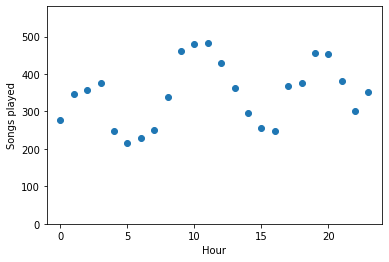

In [22]:
# create scatter plot with song count by hour
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

# Drop Rows with Missing Values

As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

In [23]:
# drop none values in userId or sessionId
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [24]:
# count how many rows in data after dropping nans
user_log_valid.count()

10000

In [25]:
# select where we would drop duplicates
# we find that there are blank userIds
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [26]:
# only include userIds where the string is not blank
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [28]:
# count how many we have now
user_log_valid.count()

9664

# Users Downgrade Their Accounts

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [29]:
# show users who have downgraded
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|   6|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [30]:
# look at the person who submitted downgrade
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "1138").collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [31]:
# map where submit downgrade is in the column
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [32]:
# create a column for the event when the person downgraded
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [33]:
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='17', downgraded=0)

In [35]:
# import window function for queries
from pyspark.sql import Window

In [36]:
# grouped by userId, and order by timestamp, when we get to the downgrade event, everything after is 0, everything beforehand is 1
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [ ]:
# TODO: filter out 0 sum and max sum to get more exact answer

function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

In [37]:
# create column
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [38]:
# select the user 1138 and sort by time
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log.userId == "1138").sort("ts").collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs

# Quiz

## Which page did user id "" (empty string) NOT visit?

In [41]:
# look at data for user "" and which page they didn't go to
user_log.select(["page"]).where(user_log.userId == "").dropDuplicates().sort('page').collect()

[Row(page='About'), Row(page='Help'), Row(page='Home'), Row(page='Login')]

## What type of user does the empty string user id most likely refer to?

In [48]:
# look at the person who submitted downgrade
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "").collect()

[Row(userId='', firstname=None, page='Login', level='free', song=None),
 Row(userId='', firstname=None, page='Home', level='paid', song=None),
 Row(userId='', firstname=None, page='Home', level='free', song=None),
 Row(userId='', firstname=None, page='Home', level='paid', song=None),
 Row(userId='', firstname=None, page='Login', level='paid', song=None),
 Row(userId='', firstname=None, page='Login', level='free', song=None),
 Row(userId='', firstname=None, page='Home', level='paid', song=None),
 Row(userId='', firstname=None, page='Home', level='paid', song=None),
 Row(userId='', firstname=None, page='Login', level='paid', song=None),
 Row(userId='', firstname=None, page='Home', level='paid', song=None),
 Row(userId='', firstname=None, page='Login', level='paid', song=None),
 Row(userId='', firstname=None, page='Home', level='paid', song=None),
 Row(userId='', firstname=None, page='Help', level='paid', song=None),
 Row(userId='', firstname=None, page='Home', level='paid', song=None),
 

In [49]:
# if song is None, it might be viewing an advertisement

## How many female users do we have in the data set?

In [59]:
# count unique userId where gender = F
user_log.select("userId").where(user_log.gender == 'F').dropDuplicates().count()

462

## How many songs were played from the most played artist?

### Who is the most played artist

In [68]:
from pyspark.sql.functions import desc

In [80]:
#get a list of top artist that were played
user_log.groupby(user_log.artist).count().sort(desc("count")).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null| 1653|
|            Coldplay|   83|
|       Kings Of Leon|   69|
|Florence + The Ma...|   52|
|            BjÃÂ¶rk|   46|
|       Dwight Yoakam|   45|
|       Justin Bieber|   43|
|      The Black Keys|   40|
|         OneRepublic|   37|
|                Muse|   36|
|        Jack Johnson|   36|
|           Radiohead|   31|
|        Taylor Swift|   29|
|          Lily Allen|   28|
|               Train|   28|
|Barry Tuckwell/Ac...|   28|
|           Daft Punk|   27|
|          Nickelback|   27|
|           Metallica|   27|
|          Kanye West|   26|
+--------------------+-----+
only showing top 20 rows



## How many songs do users listen to on average between visiting our home page? Please round your answer to the closest integer.

In [ ]:
# choose only rows with "NextSong" on page column, group by hour, and order by hour
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

songs_in_hour.show()

In [92]:
# at the Home page, group by session, count songs
user_log.filter(user_log.page == "Home").groupby(user_log.sessionId).count().show()

+---------+-----+
|sessionId|count|
+---------+-----+
|     5556|    1|
|     4894|    1|
|     4590|    1|
|     4823|    1|
|     2941|    1|
|     5418|    1|
|     2812|    2|
|     6401|    1|
|     6892|    2|
|     6834|    1|
|     5079|    2|
|     6856|    1|
|     1175|    2|
|     1919|    1|
|     6230|    1|
|     2598|    1|
|     3866|    1|
|     6806|    1|
|     4174|    1|
|     2551|    1|
+---------+-----+
only showing top 20 rows



In [ ]:
# grouped by userId, and order by timestamp, when we get to the downgrade event, everything after is 0, everything beforehand is 1
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [ ]:
# grouped by userId, and order by timestamp, when we get to the downgrade event, everything after is 0, everything beforehand is 1
windowval2 = Window.partitionBy("sessionId").orderBy(desc("ts")).